# Chess Winner Prediction Using ML Models 

The goal is to predict chess matches winner using the available data from lichess dataset. And also, explore what is the impact of rankings and openings (strategy and turns taken) in winning the game. You can inspect and download the dataset from [this url](https://www.kaggle.com/datasets/datasnaek/chess).

## About Dataset

Extracted from official dataset index.

**General Info**

This is a set of just over 20,000 games collected from a selection of users on the site Lichess.org, and how to collect more. This set contains the following features:


- Game ID;
- Rated (T/F);
- Start Time;
- End Time;
- Number of Turns;
- Game Status;
- Winner;
- Time Increment;
- White Player ID;
- White Player Rating;
- Black Player ID;
- Black Player Rating;
- All Moves in Standard Chess Notation;
- Opening Eco (Standardised Code for any given opening, [list here](https://www.365chess.com/eco.php));
- Opening Name;
- Opening Ply (Number of moves in the opening phase)

Data was collected using the [Lichess API](https://github.com/ornicar/lila), which enables collection of any given users game history.

**Possible Uses**

Lots of information is contained within a single chess game, let alone a full dataset of multiple games. It is primarily a game of patterns, and data science is all about detecting patterns in data, which is why chess has been one of the most invested in areas of AI in the past. This dataset collects all of the information available from 20,000 games and presents it in a format that is easy to process for analysis of, for example, what allows a player to win as black or white, how much meta (out-of-game) factors affect a game, the relationship between openings and victory for black and white and more.

## Imports

In [79]:
from sklearn.impute import KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import seaborn as sn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# only on notebooks
%matplotlib inline


## Exploratory Data Analysis

In [80]:
chess = pd.read_csv('games.csv')

In [81]:
chess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


In [82]:
chess.columns

Index(['id', 'rated', 'created_at', 'last_move_at', 'turns', 'victory_status',
       'winner', 'increment_code', 'white_id', 'white_rating', 'black_id',
       'black_rating', 'moves', 'opening_eco', 'opening_name', 'opening_ply'],
      dtype='object')

In [83]:
chess.describe()

,created_at,last_move_at,turns,white_rating,black_rating,opening_ply
count,2.005800e+04,2.005800e+04,20058.000000,20058.000000,20058.000000,20058.000000
mean,1.483617e+12,1.483618e+12,60.465999,1596.631868,1588.831987,4.816981
std,2.850151e+10,2.850140e+10,33.570585,291.253376,291.036126,2.797152
min,1.376772e+12,1.376772e+12,1.000000,784.000000,789.000000,1.000000
25%,1.477548e+12,1.477548e+12,37.000000,1398.000000,1391.000000,3.000000
50%,1.496010e+12,1.496010e+12,55.000000,1567.000000,1562.000000,4.000000
75%,1.503170e+12,1.503170e+12,79.000000,1793.000000,1784.000000,6.000000
max,1.504493e+12,1.504494e+12,349.000000,2700.000000,2723.000000,28.000000


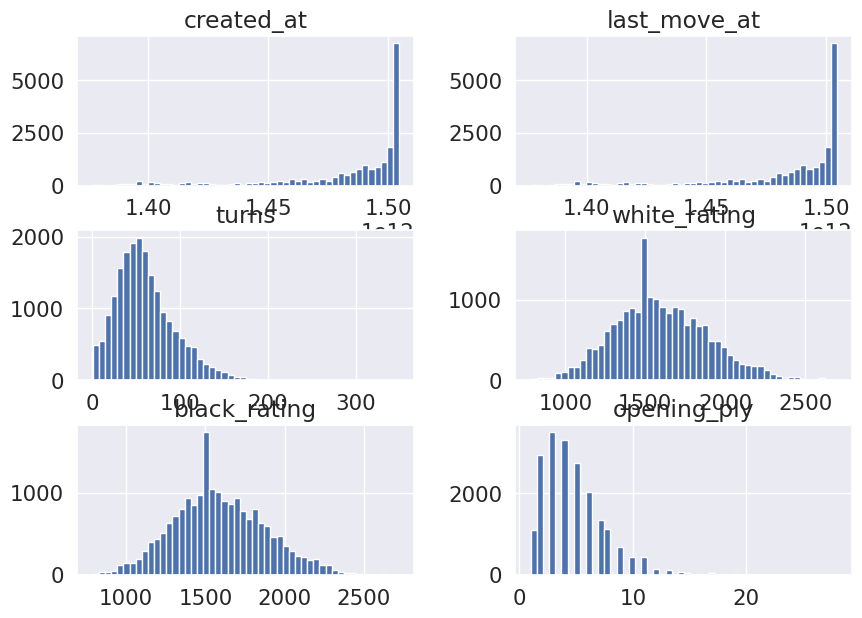

In [84]:
chess.hist(bins=50, figsize=(10,7))
plt.show()

In [85]:
print(chess['winner'].unique())

['white' 'black' 'draw']


In [86]:
print(chess['victory_status'].unique())

['outoftime' 'resign' 'mate' 'draw']


### Analysing correlations

In [87]:
# https://www.statology.org/one-hot-encoding-in-python/

def cat_encoder(df, var_array):
    encoded, categories = var_array.factorize()
    print('first values: ')
    print(encoded[:10])
    print(categories)
    encoder = OneHotEncoder()
    one_hot = encoder.fit_transform(encoded.reshape(-1, 1))
    one_hot_df = pd.DataFrame(one_hot.toarray())
    return df.join(one_hot_df)

In [88]:
chess = cat_encoder(chess, chess['winner'])

first values: 
[0 1 0 0 0 2 0 1 1 0]
Index(['white', 'black', 'draw'], dtype='object')


In [89]:
chess.rename({0: 'white_wins', 1: 'black_wins', 2: 'draw'}, axis=1, inplace=True)

Dropping draw column and values to fit problem into binnary classification

In [90]:
draws = chess.loc[chess['winner'] == 'draw']
chess.drop(draws.index, inplace=True)

In [91]:
chess.drop(['draw'], axis=1, inplace=True)

In [92]:
train_set, test_set = train_test_split(chess, test_size=0.2, random_state=42)
exp_chess = train_set.copy()
corr_matrix = exp_chess.corr()

In [93]:
corr_matrix['white_wins'].sort_values(ascending=False)

white_wins      1.000000
white_rating    0.149406
opening_ply     0.023463
rated          -0.010910
last_move_at   -0.017216
created_at     -0.017217
turns          -0.049800
black_rating   -0.164319
black_wins     -1.000000
Name: white_wins, dtype: float64

In [94]:
corr_matrix['black_wins'].sort_values(ascending=False)

black_wins      1.000000
black_rating    0.164319
turns           0.049800
created_at      0.017217
last_move_at    0.017216
rated           0.010910
opening_ply    -0.023463
white_rating   -0.149406
white_wins     -1.000000
Name: black_wins, dtype: float64

#### Exploratory assumptions

* There are no apparent linear relations between features.
* It's easier to win on white side.
* Surprisingly, player's ranks does not influence victory probabilities.
* The most common method to win is ```resign```.
* Black have better chances on longer games, winning by ```outoftime```.
* Simetrically, white have better chances on short ```opening_ply```.
* The longer the game, more chances black have to win.


## Preprocessing Pipeline

In [95]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, corr=False):
        self.columns = ["id", "created_at", "last_move_at", "increment_code", "white_id", "white_rating", "black_id",
                        "black_rating", "moves", "opening_eco", "opening_name", "opening_ply"]
        if corr:
            self.columns.append('white_wins')
            self.columns.append('black_wins')

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.drop(self.columns, axis=1)


In [96]:
class CatEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.cats = ['winner', 'rated', 'victory_status']

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        le = LabelEncoder()
        db = X.copy()
        for cat in self.cats:
            db[cat] = le.fit_transform(db[cat])
        return db

In [97]:
class MissValImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        db = X.copy()
        imputer = KNNImputer(missing_values=np.nan, n_neighbors=5)
        imputer.fit(db)
        db[:] = imputer.transform(db)
        return db

In [98]:
def normalize(val):
    val = (val-np.min(val))/(np.max(val)-np.min(val))
    return val

class Normalizer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        if columns:
            self.columns = columns
        else:
            self.columns = ['turns']
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        db = X.copy()
        for col in self.columns:
            db[col] = normalize(db[col])
        return db    


In [99]:
preprocess_pipeline = Pipeline([
    ('col_dropper', ColumnDropper(corr=True)),
    ('cat_encoder', CatEncoder()),
    ('miss_imputer', MissValImputer()),
    ('normalizer', Normalizer())
])

#### Final dataset status

In [100]:
chess = preprocess_pipeline.fit_transform(chess)
chess.head()

,rated,turns,victory_status,winner
0,0,0.034483,1,1
1,1,0.043103,2,0
2,1,0.172414,0,1
3,1,0.172414,0,1
4,1,0.270115,0,1


## Splitting Dataset using Holdout Method 

In [101]:
chess_data = chess.loc[:, chess.columns != 'winner']
chess_labels = chess['winner']

In [102]:
X_train, X_test, y_train, y_test = train_test_split(chess_data, chess_labels, test_size=0.30, random_state=42)

## Training and fine tuning Models

We will evaluate performance on the following models:

- K-nearest Neighbors
- Decision Tree
- Naive Bayes
- Neural Networks

In [103]:
def grid_scores(model):
    model.fit(X_train, y_train)
    print(f"best mean cross-validation score: {model.best_score_}")
    print(f"best parameters: {model.best_params_}")
    # do the final evaluation
    print(f"test-set score: {model.score(X_test, y_test):.3f}")


In [104]:
def train_eval_model(model):
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    return (train_acc, test_acc)

### K-nearest Neighbors

In [105]:
knn_params = {'n_neighbors': np.arange(1, 15, 2)}

knn_grid = GridSearchCV(KNeighborsClassifier(),
                        param_grid=knn_params, cv=10, return_train_score=True)

grid_scores(knn_grid)


best mean cross-validation score: 0.8520383407512748
best parameters: {'n_neighbors': 3}
test-set score: 0.856


### Decision Tree Classifier

In [106]:
dec_tree = DecisionTreeClassifier()
train_tree_acc, test_tree_acc = train_eval_model(dec_tree)
print('train accuracy: ', train_tree_acc)
print('test accuracy: ', test_tree_acc)

train accuracy:  0.8948785046728972
test accuracy:  0.8934240362811792


In [107]:
tree_para = {'criterion': ['gini', 'entropy'], 'max_depth': [
    4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150]}

tree_grid = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=10, return_train_score=True)

grid_scores(tree_grid)

best mean cross-validation score: 0.8890462103654413
best parameters: {'criterion': 'gini', 'max_depth': 120}
test-set score: 0.893


### Naive Bayes Classifier

In [108]:
from sklearn.naive_bayes import GaussianNB

gauss_nb_model = GaussianNB()

train_nb_acc, test_nb_acc = train_eval_model(gauss_nb_model)
print('train acc: ', train_nb_acc)
print('test acc: ', test_nb_acc)

train acc:  0.5268037383177571
test acc:  0.5241583813012385


In [109]:
gauss_nb_param = {
    'var_smoothing': np.logspace(0, -9, num=100)
}

gauss_nb_grid = GridSearchCV(GaussianNB(), gauss_nb_param, cv=10, n_jobs=-1)

grid_scores(gauss_nb_grid)

best mean cross-validation score: 0.5273255274452653
best parameters: {'var_smoothing': 0.001873817422860383}
test-set score: 0.526


### Neural Network

If we get more time: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

In [110]:
from sklearn.neural_network import MLPClassifier

nn_model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=42)
train_nn_acc, test_nn_acc = train_eval_model(nn_model)
print('train acc: ', train_nn_acc)
print('test acc: ', test_nn_acc)

train acc:  0.5199252336448598
test acc:  0.5314843886272458


In [111]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [112]:
GRID = [
    {'scaler': [StandardScaler()],
     'estimator': [MLPClassifier(random_state=42)],
     'estimator__solver': ['adam'],
     'estimator__learning_rate_init': [0.0001],
     'estimator__max_iter': [300],
     'estimator__hidden_layer_sizes': [(500, 400, 300, 200, 100), (400, 400, 400, 400, 400), (300, 300, 300, 300, 300), (200, 200, 200, 200, 200)],
     'estimator__activation': ['logistic', 'tanh', 'relu'],
     'estimator__alpha': [0.0001, 0.001, 0.005],
     'estimator__early_stopping': [True, False]
     }
]

PIPELINE = Pipeline([('scaler', StandardScaler()), ('estimator', MLPClassifier())])


In [113]:
# grid_search = GridSearchCV(estimator=PIPELINE, param_grid=GRID,
#                            # average='macro'),
#                            n_jobs=-1, cv=5, refit=True, verbose=1,
#                            return_train_score=False)

# grid_search.fit(X_train, y_train)
